In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

path = "/media/sarah/storage/Data/Douglas Bakkum/sampledata/"
file_name = path+'footprint.mat'
map2_name = "/media/sarah/storage/Data/Douglas Bakkum/transformed.mat"
mat_contents = sio.loadmat(file_name)
map2_image = sio.loadmat(map2_name)

In [2]:
# Load electrode coordinates
n_elec = 206
x_coord = mat_contents['footprint'][0][0][6][0]
y_coord = mat_contents['footprint'][0][0][7][0]

# Load average traces
n_samples = 101
n_traces = mat_contents['footprint'][0][0][5][0]
tot_traces = mat_contents['footprint'][0][0][4]

In [9]:
# Find the peaks of the traces
neg_peaks_idx = np.zeros((n_elec))
neg_peaks = np.zeros((n_elec))

for i in range(n_elec):
    p_idx = np.argmin(tot_traces[:,i])
    neg_peaks_idx[i] = p_idx
    neg_peaks[i] = tot_traces[p_idx,i]

biggest_ap = np.argmin(neg_peaks)

print biggest_ap

191


In [6]:
# Load MAP2 image
x_start = int(map2_image['t'][0][0][1])
x_end = int(map2_image['t'][0][0][2])
y_start = int(map2_image['t'][0][0][3])
y_end = int(map2_image['t'][0][0][4])
map2_intensity = map2_image['t'][0][0][0]

In [14]:
%matplotlib notebook

# Plot traces
dt = 1./20000
T = n_samples*dt
time = np.linspace(0,T,n_samples)

plt.figure()
for i in range(191,192): 
    peak = int(neg_peaks_idx[i])
    plt.plot(time, tot_traces[:,i], 'k')
    plt.plot(time[peak], tot_traces[peak,i], 'r.')
    
plt.show()

print time[peak]/dt

<IPython.core.display.Javascript object>

41.41


<IPython.core.display.Javascript object>


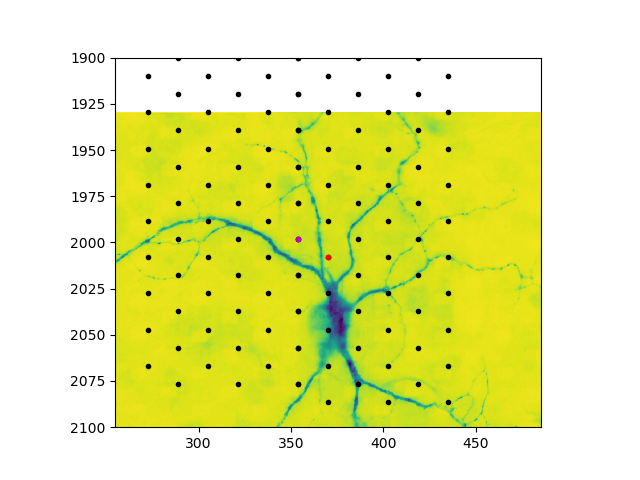

In [18]:
plt.figure()
plt.imshow(map2_intensity, extent=[x_start,x_end,y_end, y_start])
plt.plot(x_coord, y_coord, 'k.')
plt.plot(x_coord[191], y_coord[191], 'r.')
plt.plot(x_coord[43], y_coord[43], 'm.')
plt.ylim((2100, 1900))
plt.xlim((x_start,x_end))

plt.show()

<IPython.core.display.Javascript object>


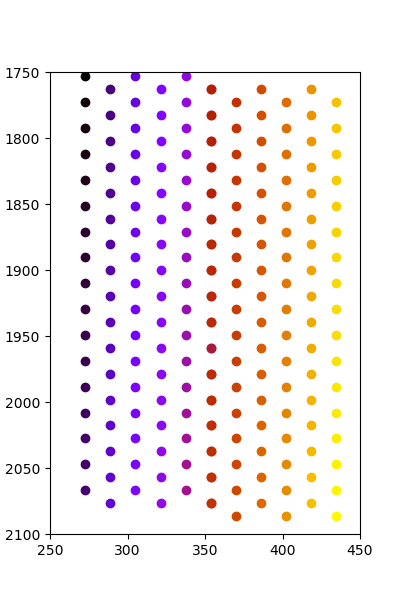

In [19]:
# Sorting the data

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n_elec)]

# Sorting in x-dir

sorted_xind = np.argsort(x_coord)

# Sorting in y-dir

sorted_yind = np.zeros((n_elec-2))

for i in range(12):
    xx = y_coord[sorted_xind][17*i:17*(i+1)]
    #print xx
    #print x_coord[sorted_xind][17*i:17*(i+1)]
    sort_xx = np.argsort(xx) + int(17*i)
    #print sort_xx
    #print y_coord[sorted_xind][sort_xx]
    sorted_yind[17*i:17*(i+1)] = sort_xx

sorted_yind = sorted_yind.astype(int)

plt.figure(figsize=(4,6))

for i in range(n_elec-2):
    ind = int(sorted_yind[i])
    plt.plot(x_coord[sorted_xind][ind], y_coord[sorted_xind][ind], color= colors[i], marker='o')
plt.ylim((2100, 1750))
plt.xlim((250,450))

plt.show()

In [20]:
# Sort all the data

sorted_xcoord = x_coord[sorted_xind][sorted_yind]
sorted_ycoord = y_coord[sorted_xind][sorted_yind]

sorted_ntraces = n_traces[sorted_xind][sorted_yind]
sorted_tottraces = tot_traces[:,sorted_xind][:,sorted_yind]

In [21]:
# Distance between to points

def distance_inter_elec(x1, x2):
    dx = x1[0]-x2[0]
    dy = x1[1]-x2[1]
    return np.abs(dx), np.abs(dy), np.sqrt(dx**2+dy**2)

#print distance_inter_elec([sorted_xcoord[5], sorted_ycoord[5]], [sorted_xcoord[50], sorted_ycoord[50]])

# Electric field at a point 

def field_on_grid(pos, xcoord, ycoord, V, t):
    xp = [xcoord[pos], ycoord[pos]]
    ne = len(xcoord)
    Ex = 0
    Ey = 0
    for i in [x for x in xrange(ne) if x != pos]:
        xc = [xcoord[i], ycoord[i]]
        dx = distance_inter_elec(xp, xc)[0]
        dy = distance_inter_elec(xp, xc)[1]
        dV = V[t, pos] - V[t, i]
        if dx == 0:
            ex = 0
        else:
            ex = dV/dx
        if dy == 0:
            ey = 0
        else:
            ey = dV/dy
        #print ex, ey
        Ex += ex
        Ey += ey
        
    return [Ex, Ey]

#fie = field_on_grid(54, sorted_xcoord, sorted_ycoord, sorted_tottraces, 10)

In [22]:
ne  = len(sorted_xcoord)

Ex = np.zeros((ne))
Ey = np.zeros((ne))

for i in range(ne):
    e = field_on_grid(i, sorted_xcoord, sorted_ycoord, sorted_tottraces, 45)
    Ex[i] = e[0]
    Ey[i] = e[1]

<IPython.core.display.Javascript object>


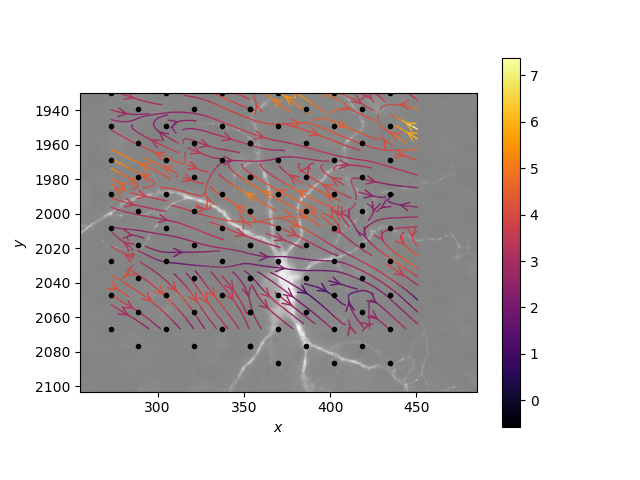

In [23]:
# Grid of x, y points

# !!! Everything is shifted because the grid is rectangular, which is not the case of the electrode positions -> 
# try to make the grid by hand

Ex_cut = Ex.reshape((17,12))
Ey_cut = Ey.reshape((17,12))
pot = sorted_tottraces[50,:].reshape((17,12))

x = sorted_xcoord[::17]
y = sorted_ycoord[:17]
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color = np.log(np.hypot(Ex_cut, Ey_cut))
im = ax.streamplot(x, y, Ex_cut, Ey_cut, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)
ax.plot(sorted_xcoord, sorted_ycoord, 'k.')
ax.imshow(map2_intensity, extent=[x_start,x_end,y_end, y_start], cmap='binary', alpha=0.5)
#ax.contourf(x, y, pot, alpha=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
fig.colorbar(im.lines)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


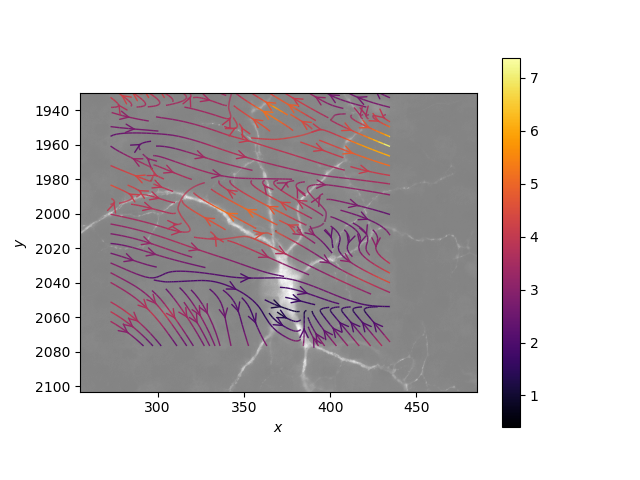

In [25]:
# Grid of x, y points

# !!! Everything is shifted because the grid is rectangular, which is not the case of the electrode positions -> 
# try to make the grid by hand

Ex1 = Ex.reshape((17,12))[:,::2]
Ey1 = Ey.reshape((17,12))[:,::2]
Ex2 = Ex.reshape((17,12))[:,1::2]
Ey2 = Ey.reshape((17,12))[:,1::2]

x1 = sorted_xcoord[::34]
y1 = sorted_ycoord[:17]
X1, Y1 = np.meshgrid(x1, y1)
x2 = sorted_xcoord[1::34]
y2 = sorted_ycoord[17:34]
X2, Y2 = np.meshgrid(x2, y2)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

# Plot the streamlines with an appropriate colormap and arrow style
color1 = np.log(np.hypot(Ex1, Ey1))
im1 = ax1.streamplot(x1, y1, Ex1, Ey1, color=color1, linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)
ax1.imshow(map2_intensity, extent=[x_start,x_end,y_end, y_start], cmap='binary', alpha=0.5)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_aspect('equal')
fig1.colorbar(im1.lines)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

color2 = np.log(np.hypot(Ex2, Ey2))
im2 = ax2.streamplot(x2, y2, Ex2, Ey2, color=color2, linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)
ax2.imshow(map2_intensity, extent=[x_start,x_end,y_end, y_start], cmap='binary', alpha=0.5)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_aspect('equal')
fig2.colorbar(im2.lines)

plt.show()

In [26]:
# With interpolation

ny=17

# One array with all the y values
y_full = np.zeros((2*ny))
y_full[::2] = y1
y_full[1::2] = y2

# Data points
x_d = sorted_xcoord
y_d = sorted_ycoord

# Define the grid
x_m = sorted_xcoord[::17]
y_m = y_full
X_m, Y_m = np.meshgrid(x_m, y_m)

# Grid the data.
Ex_interp = griddata((x_d, y_d), Ex, (X_m, Y_m), method='cubic')
Ey_interp = griddata((x_d, y_d), Ey, (X_m, Y_m), method='cubic')

<IPython.core.display.Javascript object>


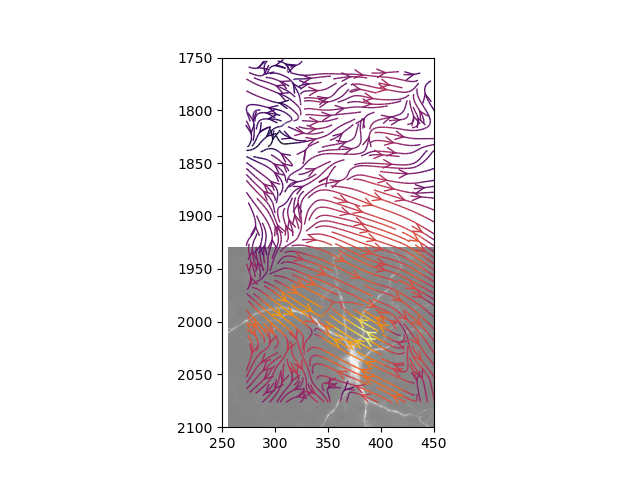

/home/sarah/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


In [27]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
color = np.log(np.hypot(Ex_interp, Ey_interp))
ax.streamplot(X_m, Y_m, Ex_interp, Ey_interp, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)
ax.imshow(map2_intensity, extent=[x_start,x_end,y_end, y_start], cmap='binary', alpha=0.5)
ax.set_aspect('equal')
ax.set_ylim((2100, 1750))
#ax.set_ylim((1750, 2100))
ax.set_xlim((250,450))

plt.show()

<IPython.core.display.Javascript object>


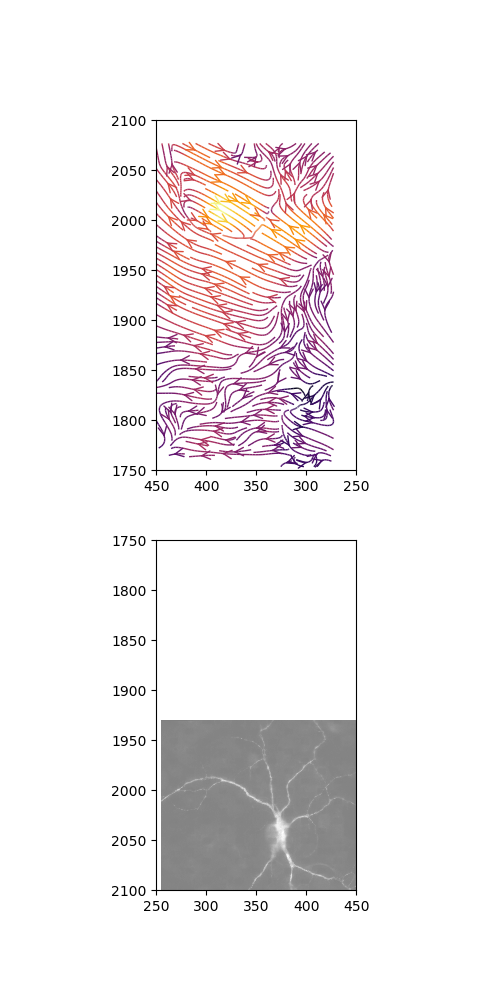

In [28]:
# Plot

plt.figure(figsize=(5,10))
ax1 = plt.subplot(211)
color = np.log(np.hypot(Ex_interp, Ey_interp))
ax1.streamplot(X_m, Y_m, Ex_interp, Ey_interp, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=2, arrowstyle='->', arrowsize=1.5)
#ax.imshow(map2_intensity, extent=[x_start,x_end,y_start, y_end], cmap='binary', alpha=0.5)
ax1.set_aspect('equal')
#ax1.set_ylim((2100, 1750))
ax1.set_ylim((1750, 2100))
#ax1.set_xlim((250,450))
ax1.set_xlim((450,250))

ax2 = plt.subplot(212)
ax2.imshow(map2_intensity, extent=[x_start,x_end,y_end, y_start], cmap='binary', alpha=0.5)
ax2.set_aspect('equal')
ax2.set_ylim((2100, 1750))
#ax2.set_ylim((1750, 2100))
ax2.set_xlim((250,450))

plt.show()

<IPython.core.display.Javascript object>


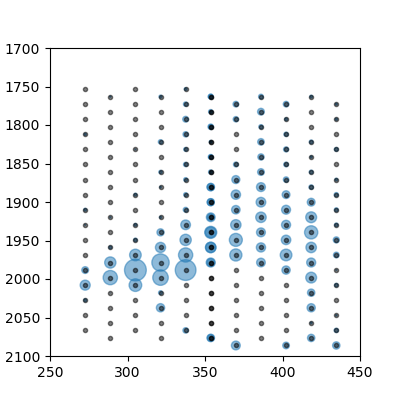

/home/sarah/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<IPython.core.display.Javascript object>


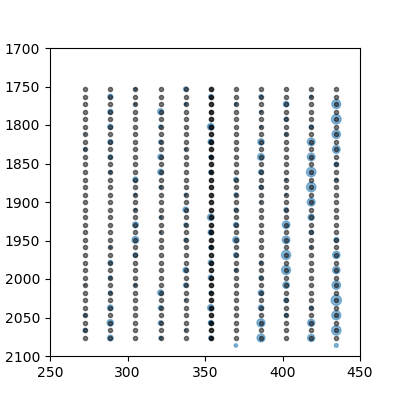

In [29]:
plt.figure(figsize=(4,4))
plt.plot(x_coord, y_coord, 'k.', alpha=0.5)
#plt.plot(X_m, Y_m, 'k.')
#plt.scatter(x_d, y_d, Ex_interp, 'g', alpha=0.5)
plt.scatter(sorted_xcoord, sorted_ycoord, Ex, alpha=0.5)
plt.ylim((2100, 1700))
plt.xlim((250,450))

plt.figure(figsize=(4,4))
#plt.plot(x_coord, y_coord, 'ro', alpha=0.3)
plt.plot(X_m, Y_m, 'k.', alpha=0.5)
plt.scatter(x_d, y_d, Ex_interp, alpha=0.5)
#plt.scatter(sorted_xcoord, sorted_ycoord, Ex, alpha=0.5)
plt.ylim((2100, 1700))
plt.xlim((250,450))


plt.show()